In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from env import get_db_url
from acquire import get_db_log_data
from wrangle import wrangle_df

# Acquire:

I need to figure out why these are coming out differently after the join. 
- There's a difference of 52,887 records.
    - It looks like the difference here is due to having 52,893 null values in logs.cohort_id.
    - There are 6 cohorts in the cohorts_id table that do not have any server traffic, so perhaps they didn't exist.
    - 52,887 that didn't have anything to tie them to the cohorts table. Probably cohort ids - come back and verify.
- it appears that there there are some IDs and Cohort IDs that do not much.

In [2]:
def wrangle_df(df):
    
    '''This function takes in a DataFrame of curriculum access logs, does some basic wrangling like 
    mapping program codes to program ID numbers, drops unneeded or duplicated columns, 
    and changes date columns to the datetime data type.'''
    
    #Updates program ID numbers to their respective program titles:
    df.program_id = df.program_id.map({1.0:'full_stack_php', 2.0:'full_stack_java', 3.0:'data_science', 4.0:'front_end_programming'})
    
    ## Drops unneeded or duplicate columns:
    df.drop(columns=['id','slack','deleted_at'],inplace = True)
    
    #Adding a date_time column for a test:
    df['date_time'] = pd.to_datetime(df['date']+ ' ' + df['time'])
    
    #Creates a list of columns containing relevant date data for logs:
    date_cols = ['date', 'start_date', 'end_date', 'created_at', 'updated_at']
    
    #Iterates through list of dates to change them to datetime data type:
    for col in date_cols: 
        df[col] = pd.to_datetime(df[col])
    return df     

## Importing from the database using SQL or Cached Data:

In [3]:
df = get_db_log_data()

In [4]:
df.sample()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
494147,2020-03-26,22:00:52,javascript-ii/map-filter-reduce,599,56.0,76.184.67.169,56.0,Apex,#apex,2020-02-24,2020-07-29,2020-02-24 15:39:33,2020-07-29 18:41:13,NaN,2.0


# Wrangle:

## To-Do:
    - Figure out what created_at and updated_at columns are. 

In [5]:
df = wrangle_df(df)

In [6]:
#TEMPORARILY Dropping Nulls for Question 5:
df = df.dropna()
df.shape[0]

847329

In [7]:
#Defining the function that adds the program type column based on program_id:
def program_type(df):
    #Creating an empty column on the DataFrame:
    df['program_type'] = pd.Series()
    #Calling type 'web' if program_id is not data_science
    if df.program_id != 'data_science':
        df.program_type ='web'
    #Creating type 'data' if program_id is data:
    elif df.program_id == 'data_science':
        df.program_type = 'data'
    #Returning DataFrame with new program_type column:
    return df

In [8]:
#Updating DataFrame with program_type column:

df = df.apply(program_type, 1)

/var/folders/dk/lzs3plw14ms00nxw2vwq68vc0000gn/T/ipykernel_61721/1368827443.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['program_type'] = pd.Series()


In [9]:
df.shape[0]

847329

In [10]:
df[df.path.isnull()]

,date,time,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,date_time,program_type


## May not need this cell below, as I'm only looking at 2019 data:

In [11]:
#Dropping row where the path is null:
#df = df.drop(df.index[506305])

# Questions:

## 5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

### Finding logs of student access for the year of 2019:

In [12]:
#Setting earliest date to 12/31/18:
first_date = dt.datetime(2018, 12, 31)
#Setting latest date to 1/1/20:
second_date = dt.datetime(2020, 1, 1)

#Creating a DataFrame containing only records within above rage:
log_2019 = df[(df.date > first_date) & (df.date < second_date)]

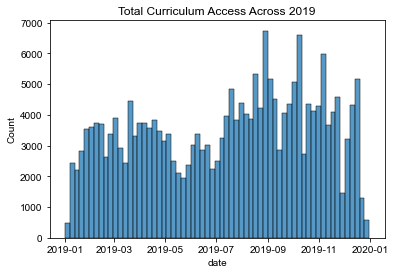

In [13]:
sns.histplot(data = log_2019, x = log_2019.date).set(title = "Total Curriculum Access Across 2019")
sns.set(rc = {'figure.figsize':(16,9)});

In [14]:
#Searching for 'java' in path name to identify some web dev courses, saving to web_courses df:
web_courses = log_2019[log_2019.path.str.contains('java', regex=False)]
web_courses.shape[0]

82886

In [15]:
#Checking to see how many web students accessed these courses:
wd_in_wd = web_courses[web_courses.program_type == 'web']
wd_in_wd.shape[0]

82854

In [16]:
#Creating a dataframe showing data students accessing web dev content:
ds_in_wd = web_courses[web_courses.program_type == 'data']
ds_in_wd.shape[0]
#This seems to show that data students accessed web material as late as 12/14, which seems odd.

32

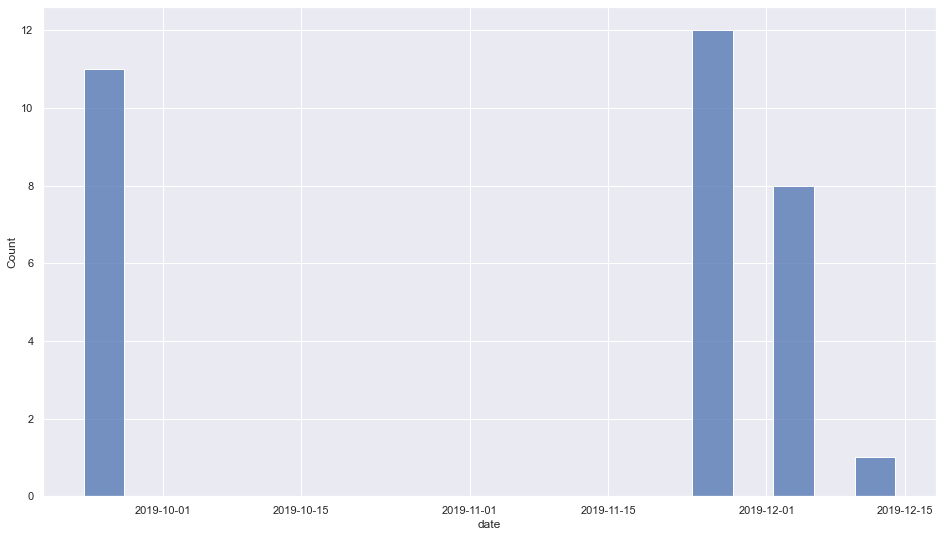

In [17]:
#This plot shows the data student access to web dev courses:
sns.histplot(data = ds_in_wd, x = 'date', bins = 20)
sns.set(rc = {'figure.figsize':(16,9)});

In [18]:
#Identifying which data students accessed the web dev content:
ds_in_wd.user_id.unique()

#It looks like users 476, 467, and 472 accessed java content.

array([476, 467, 472])

## Looking into users 476, 467, and 472:

In [19]:
df[df.user_id == 476].head()

,date,time,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,date_time,program_type
326063,2019-08-20,09:40:23,/,476,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,data_science,2019-08-20 09:40:23,data
326165,2019-08-20,10:04:25,/,476,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,data_science,2019-08-20 10:04:25,data
326168,2019-08-20,10:07:20,/,476,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,data_science,2019-08-20 10:07:20,data
326293,2019-08-20,10:49:50,1-fundamentals/1.1-intro-to-data-science,476,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,data_science,2019-08-20 10:49:50,data
326294,2019-08-20,10:49:50,1-fundamentals/modern-data-scientist.jpg,476,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,data_science,2019-08-20 10:49:50,data


In [20]:
df.name.unique()

array(['Hampton', 'Teddy', 'Sequoia', 'Arches', 'Niagara', 'Pinnacles',
       'Quincy', 'Kings', 'Lassen', 'Mammoth', 'Glacier', 'Denali',
       'Joshua', 'Olympic', 'Ulysses', 'Badlands', 'Apollo', 'Ike',
       'Voyageurs', 'Wrangell', 'Xanadu', 'Franklin', 'Yosemite', 'Staff',
       'Zion', 'Andromeda', 'Betelgeuse', 'Ceres', 'Bayes', 'Deimos',
       'Europa', 'Fortuna', 'Curie', 'Apex', 'Ganymede', 'Everglades',
       'Hyperion', 'Darden', 'Bash', 'Jupiter', 'Kalypso', 'Luna',
       'Easley', 'Marco', 'Neptune', 'Florence', 'Oberon'], dtype=object)

In [21]:
#Creating a dataframe containing all rolls that are missing a cohort name:
name_nulls_df = df[~df.name.isin(['Hampton', 'Teddy', 'Sequoia', 'Arches', 'Niagara', 'Pinnacles',
       'Quincy','Kings', 'Lassen', 'Mammoth', 'Glacier', 'Denali',
       'Joshua', 'Olympic', 'Ulysses', 'Badlands', 'Apollo', 'Ike',
       'Voyageurs', 'Wrangell', 'Xanadu', 'Franklin', 'Yosemite', 'Staff',
       'Zion', 'Andromeda', 'Betelgeuse', 'Ceres', 'Bayes', 'Deimos',
       'Europa', 'Fortuna', 'Curie', 'Apex', 'Ganymede', 'Everglades',
       'Hyperion', 'Darden', 'Bash', 'Jupiter', 'Kalypso', 'Luna',
       'Easley', 'Marco', 'Neptune', 'Florence', 'Oberon'])]

In [22]:
name_nulls_df.path.value_counts().head(10)

Series([], Name: path, dtype: int64)

In [23]:
first_date = dt.datetime(2019, 1, 31)

In [24]:
#Using regex to include more web_dev-related keywords in search:
web_courses2 = name_nulls_df[name_nulls_df.path.str.contains('html|css|java|spring', regex=True, flags=re.IGNORECASE)] 
web_courses2[(web_courses2.date > first_date) & (web_courses2.date < second_date)]

,date,time,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,date_time,program_type


In [25]:
#Creating a dataframe containing all rows that are missing a cohort name:
name_nulls_df = df[~df.name.isin(['Hampton', 'Teddy', 'Sequoia', 'Arches', 'Niagara', 'Pinnacles',
       'Quincy','Kings', 'Lassen', 'Mammoth', 'Glacier', 'Denali',
       'Joshua', 'Olympic', 'Ulysses', 'Badlands', 'Apollo', 'Ike',
       'Voyageurs', 'Wrangell', 'Xanadu', 'Franklin', 'Yosemite', 'Staff',
       'Zion', 'Andromeda', 'Betelgeuse', 'Ceres', 'Bayes', 'Deimos',
       'Europa', 'Fortuna', 'Curie', 'Apex', 'Ganymede', 'Everglades',
       'Hyperion', 'Darden', 'Bash', 'Jupiter', 'Kalypso', 'Luna',
       'Easley', 'Marco', 'Neptune', 'Florence', 'Oberon'])]

In [26]:
#Looking at the topcics accessed by users missing a cohort name:
name_nulls_df[(name_nulls_df.date > first_date) & (web_courses2.date < second_date)].path.unique()

array([], dtype=object)

In [27]:
#Defining start and end dates that correspond to Ada's:
start_date = dt.datetime(2019, 2, 14)
end_date = dt.datetime(2019, 6, 16)

In [28]:
#Checking to see which logged items fell within the range of Ada's active days:
df[(df.date > start_date) & (df.date < end_date)]

,date,time,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,date_time,program_type
199368,2019-02-15,06:01:49,javascript-i/arrays/manipulating,343,29.0,72.181.110.80,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,full_stack_java,2019-02-15 06:01:49,web
199369,2019-02-15,06:02:02,javascript-i/objects,343,29.0,72.181.110.80,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,full_stack_java,2019-02-15 06:02:02,web
199370,2019-02-15,06:02:27,javascript-i/arrays/manipulating,343,29.0,72.181.110.80,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,full_stack_java,2019-02-15 06:02:27,web
199371,2019-02-15,06:02:31,javascript-i/arrays,343,29.0,72.181.110.80,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,full_stack_java,2019-02-15 06:02:31,web
199372,2019-02-15,06:07:57,javascript-i/arrays/manipulating,343,29.0,72.181.110.80,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,full_stack_java,2019-02-15 06:07:57,web
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283857,2019-06-15,21:16:41,java-iii/deployment-and-dependencies,376,31.0,71.42.211.139,Andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,full_stack_java,2019-06-15 21:16:41,web
283858,2019-06-15,21:16:43,java-iii/servlets,376,31.0,71.42.211.139,Andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,full_stack_java,2019-06-15 21:16:43,web
283859,2019-06-15,21:35:13,javascript-i/testing-user-functions,315,26.0,24.26.232.177,Xanadu,2018-09-17,2019-02-08,2018-09-17 19:09:51,2018-09-17 19:09:51,full_stack_java,2019-06-15 21:35:13,web
283860,2019-06-15,23:50:25,java-iii/jdbc,376,31.0,192.171.117.210,Andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,full_stack_java,2019-06-15 23:50:25,web


In [29]:
#Seeing which items were most often visited by user 368:
df[df.user_id == 368].path.value_counts().head(15)

Series([], Name: path, dtype: int64)

In [30]:
#Using this list to keep note of some key DS keywords to search for:
df[df.user_id == 368].path.value_counts()

Series([], Name: path, dtype: int64)

### Trying from the other direction - web dev accessing ds material:

In [31]:
#Searching for 'java' in path name to identify some web dev courses, saving to web_courses df:
data_courses = log_2019[log_2019.path.str.contains('excel|Regression|mysql|Probability', regex=True, flags=re.IGNORECASE)]
data_courses.head(1)

,date,time,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,date_time,program_type
175820,2019-01-01,16:38:45,mysql,262,26.0,97.105.90.179,Xanadu,2018-09-17,2019-02-08,2018-09-17 19:09:51,2018-09-17 19:09:51,full_stack_java,2019-01-01 16:38:45,web


In [32]:
#Setting earliest date to 12/31/17:
first_date = dt.datetime(2013, 12, 31)
#Setting latest date to 1/1/20:
second_date = dt.datetime(2022, 1, 1)

#Creating a DataFrame containing only records within above rage:
data_crossover = data_courses[(data_courses.date > first_date) & (data_courses.date < second_date)]

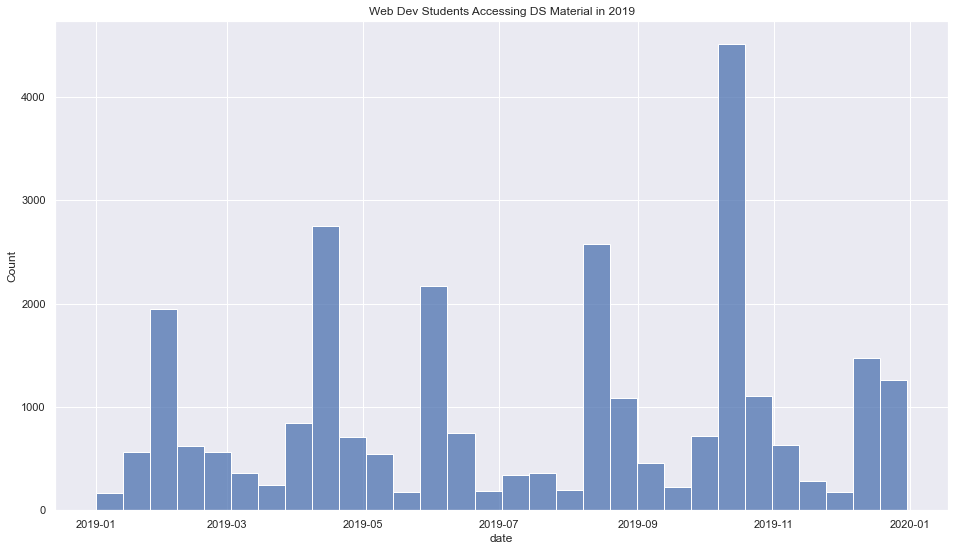

In [33]:
sns.set(rc = {'figure.figsize':(16,9)})
sns.histplot(data = data_crossover, x = data_crossover.date).set(title = "Web Dev Students Accessing DS Material in 2019");


### I'm going to try changing the dates and see what happens:

In [36]:
#Setting earliest date to 12/31/17:
first_date = dt.datetime(2017, 12, 31)
#Setting latest date to 1/1/20:
second_date = dt.datetime(2020, 1, 1)

#Creating a DataFrame containing only records within above rage:
log_18_19 = df[(df.date > first_date) & (df.date < second_date)]

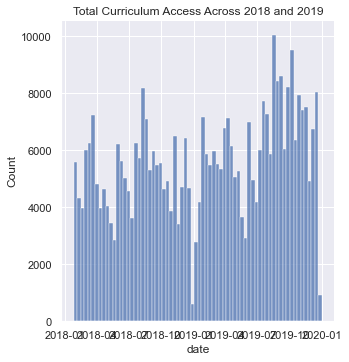

In [37]:
sns.displot(data = log_18_19, x = log_18_19.date).set(title = "Total Curriculum Access Across 2018 and 2019")
sns.set(rc = {'figure.figsize':(16,9)});

In [38]:
#Searching for 'java' in path name to identify some web dev courses for both 18 and 19, saving to web_courses2 df:
data_courses =log_18_19[log_18_19.path.str.contains('excel|Regression|mysql|Probability', regex=True, flags=re.IGNORECASE)]

In [39]:
data_courses

,date,time,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,date_time,program_type
149,2018-01-26,11:48:17,mysql,16,21.0,97.105.19.61,Sequoia,2017-09-27,2018-02-15,2017-09-27 20:22:41,2017-09-27 20:22:41,full_stack_java,2018-01-26 11:48:17,web
234,2018-01-26,13:51:13,mysql,36,21.0,97.105.19.61,Sequoia,2017-09-27,2018-02-15,2017-09-27 20:22:41,2017-09-27 20:22:41,full_stack_java,2018-01-26 13:51:13,web
235,2018-01-26,13:51:15,mysql/users,36,21.0,97.105.19.61,Sequoia,2017-09-27,2018-02-15,2017-09-27 20:22:41,2017-09-27 20:22:41,full_stack_java,2018-01-26 13:51:15,web
236,2018-01-26,13:51:17,mysql/sample-database,36,21.0,97.105.19.61,Sequoia,2017-09-27,2018-02-15,2017-09-27 20:22:41,2017-09-27 20:22:41,full_stack_java,2018-01-26 13:51:17,web
238,2018-01-26,13:51:24,mysql/functions,36,21.0,97.105.19.61,Sequoia,2017-09-27,2018-02-15,2017-09-27 20:22:41,2017-09-27 20:22:41,full_stack_java,2018-01-26 13:51:24,web
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421866,2019-12-31,07:37:38,mysql/users,489,51.0,66.25.173.125,Deimos,2019-09-16,2020-02-27,2019-09-16 13:07:04,2019-09-16 13:07:04,full_stack_java,2019-12-31 07:37:38,web
421867,2019-12-31,07:39:50,mysql/databases,489,51.0,66.25.173.125,Deimos,2019-09-16,2020-02-27,2019-09-16 13:07:04,2019-09-16 13:07:04,full_stack_java,2019-12-31 07:39:50,web
421868,2019-12-31,07:41:53,mysql/tables,489,51.0,66.25.173.125,Deimos,2019-09-16,2020-02-27,2019-09-16 13:07:04,2019-09-16 13:07:04,full_stack_java,2019-12-31 07:41:53,web
421875,2019-12-31,09:08:28,mysql,509,51.0,108.71.183.46,Deimos,2019-09-16,2020-02-27,2019-09-16 13:07:04,2019-09-16 13:07:04,full_stack_java,2019-12-31 09:08:28,web


In [40]:
#Creating a dataframe showing data students accessing web dev content in 18 AND 19, called ds_in_wd2:
ds_in_wd2 = web_courses2[web_courses2.program_type == 'data']
ds_in_wd2.shape[0]

0

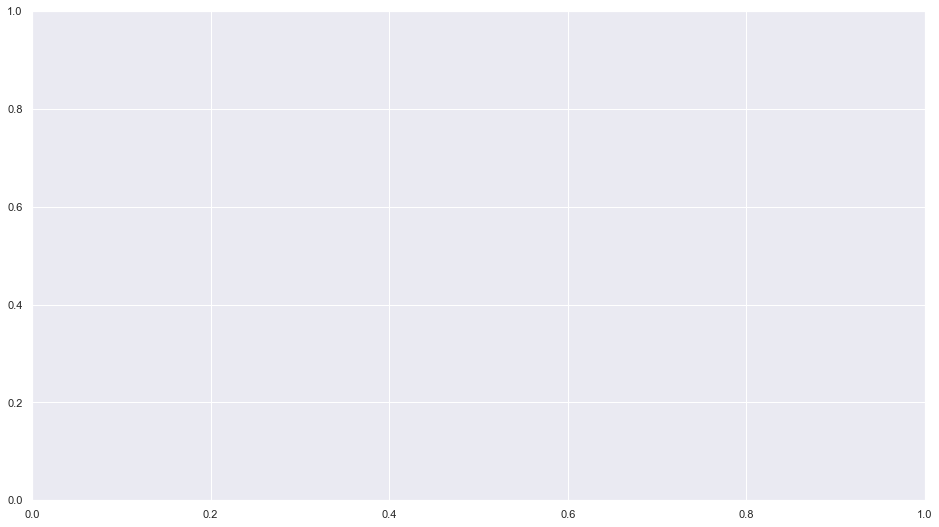

In [41]:
#This plot shows the data student access to web dev courses:
sns.histplot(data = ds_in_wd2, x = 'date', bins = 20)
sns.set(rc = {'figure.figsize':(16,9)});

### Trying to Identify Instances of Students Accessing Other Curriculum:

In [42]:
df2.apply(program_type, 1)

NameError: name 'df2' is not defined

In [ ]:
df[df.program_id.isnull()]

In [ ]:
data_students = df[df.program_id == 'data_science']
web_students = df[(df.program_id != 'data_science') & (df.program_id != None)].dropna()

In [ ]:
web_students

In [ ]:
data_students

In [ ]:
df

In [ ]:
web_to_data = df[(df.program_id == 'full_stack_java') & df.path]

In [ ]:
df.program_id.unique()

## 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

## 7. Which lessons are least accessed?

## 8. Anything else I should be aware of?

# Extra Functionality:

In [ ]:
#Identifying active students:
df[ (df.date > df.start_date) & (df.date < df.end_date)]

In [ ]:
#Adding column of how long students were actively in the program:
df['tenure'] = df.end_date - df.start_date

# Final Summary Section:

## Acquiring Data:

In [43]:
#Getting the data from the database and caching it into a CSV:
df = get_db_log_data()

In [44]:
df = wrangle_df(df)

In [45]:
df = df.dropna()

In [46]:
#Defining the function that adds the program type column based on program_id:
def program_type(df):
    #Creating an empty column on the DataFrame:
    df['program_type'] = pd.Series()
    #Calling type 'web' if program_id is not data_science
    if df.program_id != 'data_science':
        df.program_type ='web'
    #Creating type 'data' if program_id is data:
    elif df.program_id == 'data_science':
        df.program_type = 'data'
    #Returning DataFrame with new program_type column:
    return df

In [47]:
df = df.apply(program_type, 1)

/var/folders/dk/lzs3plw14ms00nxw2vwq68vc0000gn/T/ipykernel_61721/1368827443.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['program_type'] = pd.Series()


## Determining Crossover from Web Development to Data Science:

In [52]:
web_students = df[df.program_type == 'web']
data_students = df[df.program_type == 'data']

In [50]:
#Setting earliest date to 12/31/18:
first_date = dt.datetime(2018, 12, 31)
#Setting latest date to 1/1/20:
second_date = dt.datetime(2020, 1, 1)

#Creating a DataFrame containing only records within above range:
web_dev_log = web_students[(web_students.date > first_date) & (web_students.date < second_date)]

In [56]:
#Searching for 'java' in path name to identify some web dev courses for both 18 and 19, saving to web_courses2 df:
web_crossover = web_dev_log[web_dev_log.path.str.contains('excel|Regression|mysql|Probability', regex=True, flags=re.IGNORECASE)]

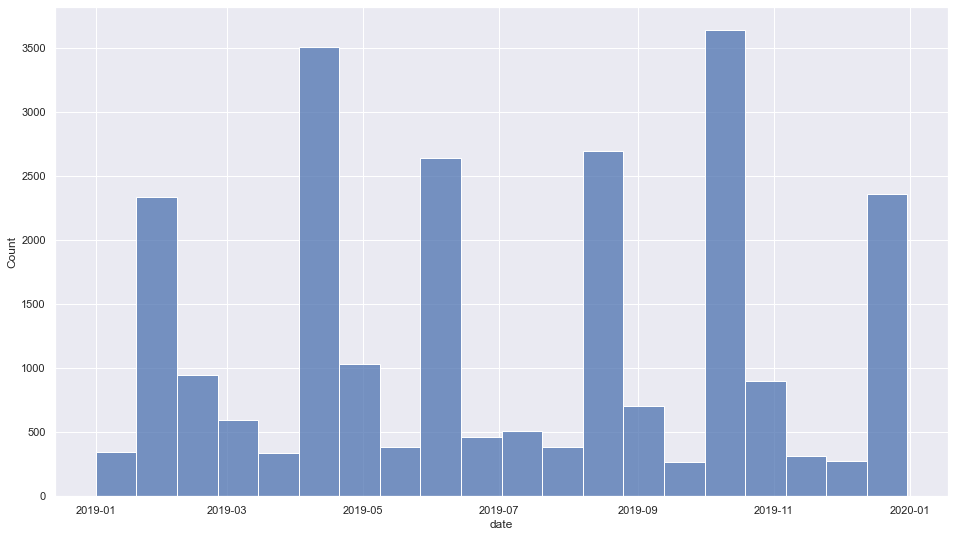

In [57]:
#This plot shows the web student access to data courses:
sns.histplot(data = web_crossover, x = 'date', bins = 20)
sns.set(rc = {'figure.figsize':(16,9)});

## Determining Cross Over From Data Science to Web Development:

In [53]:
#Setting earliest date to 12/31/18:
first_date = dt.datetime(2018, 12, 31)
#Setting latest date to 1/1/20:
second_date = dt.datetime(2020, 1, 1)

#Creating a DataFrame containing only records within above range:
data_log = data_students[(data_students.date > first_date) & (data_students.date < second_date)]

In [58]:
#Searching for 'java' in path name to identify some web dev courses for both 18 and 19, saving to web_courses2 df:
data_crossover = data_log[data_log.path.str.contains('html|css|java|spring', regex=True, flags=re.IGNORECASE)]

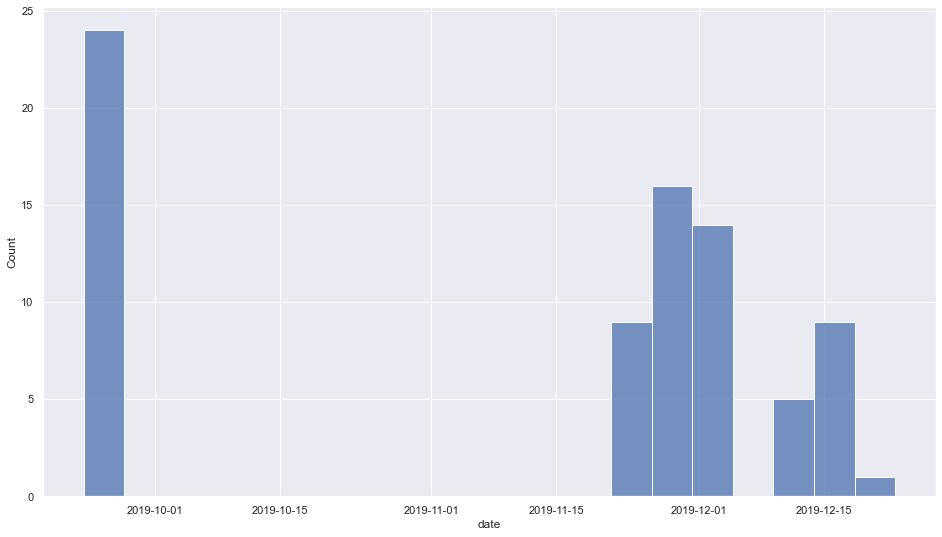

In [59]:
#This plot shows the data student access to web dev courses:
sns.histplot(data = data_crossover, x = 'date', bins = 20)
sns.set(rc = {'figure.figsize':(16,9)});